In [1]:
import pandas as pd
import numpy as np
import altair as alt

In [87]:
# Read in .csv as DataFrame
df_full = pd.read_csv('crispr_pax7_sox9_section_counts.csv')

# Add empty columns for totals
df_full['cntl pax7 total'] = df_full['Cntl Pax7 Tube Cells'] + df_full['Cntl Pax7 Mig Cells']
df_full['expt pax7 total'] = df_full['Expt Pax7 Tube Cells'] + df_full['Expt Pax7 Mig Cells']

In [88]:
df_full.head(2)

,Experiment,Treatment (right/left),Reagent,Dose,Embryo,Somites,HH Stage,File Name,Section,Cntl Pax7 Tube Cells,Cntl Pax7 Mig Cells,Expt Pax7 Tube Cells,Expt Pax7 Mig Cells,Cntl Sox9 Cells,Expt Sox9 Cells,cntl pax7 total,expt pax7 total
0,2017.10.16_SMPD3_gRNA1_Cas9eGFP,SMPD3 gRNA1/Control gRNA,Cas9eGFP,2 µg/µl,1,7,9,Emb1_7ss_sec1.czi,1,18,23,15,13,23,18,41,28
1,2017.10.16_SMPD3_gRNA1_Cas9eGFP,SMPD3 gRNA1/Control gRNA,Cas9eGFP,2 µg/µl,1,7,9,Emb1_7ss_sec2.czi,2,19,28,18,14,33,14,47,32


## This approach didn't work

In [85]:
embryo_means = (df_full.groupby(['Embryo', 'Section', 'HH Stage'])['cntl pax7 total', 'expt pax7 total', 'Cntl Sox9 Cells', 'Expt Sox9 Cells']).mean()
embryo_means['pax7 ratio'] = embryo_means['expt pax7 total'] / embryo_means['cntl pax7 total']
embryo_means['sox9 ratio'] = embryo_means['Expt Sox9 Cells'] / embryo_means['Cntl Sox9 Cells']
avg_ratios = (embryo_means.groupby(['Embryo', 'HH Stage'])['pax7 ratio', 'sox9 ratio']).mean()
avg_ratios

,,pax7 ratio,sox9 ratio
Embryo,HH Stage,,
1,9,0.713775,0.556974
2,9,1.002373,0.900963
3,9,0.940568,1.135784
4,10,0.844730,0.679111
5,9,0.715297,0.695783
6,9,1.268132,1.276685
7,9,0.901577,0.981758
8,10,0.740359,1.048656
9,9,1.510761,inf


This is a problem because one of the sections had a zero count, so 0/# generated an infinity (inf). Need to revise data analysis to prevent this from happening, and I'll approach this by averaging the counts per side before generating the ratio.

## This one works better

In [100]:
# This approach does work
embryo_means = (df_full.groupby(['Embryo', 'HH Stage'])['cntl pax7 total', 'expt pax7 total', 'Cntl Sox9 Cells', 'Expt Sox9 Cells']).mean()
embryo_means['pax7 ratio'] = embryo_means['expt pax7 total'] / embryo_means['cntl pax7 total']
embryo_means['sox9 ratio'] = embryo_means['Expt Sox9 Cells'] / embryo_means['Cntl Sox9 Cells']
avg_ratios = (embryo_means.groupby(['Embryo', 'HH Stage'])['pax7 ratio', 'sox9 ratio']).mean().reset_index()
avg_ratios_hh9 = (avg_ratios.loc[avg_ratios['HH Stage'] == 9])

,Embryo,HH Stage,pax7 ratio,sox9 ratio
0,1,9,0.641304,0.540323
1,2,9,1.034483,0.890756
2,3,9,0.947368,1.112903
3,4,10,0.807829,0.652850
4,5,9,0.706522,0.689320
5,6,9,1.344828,1.453846
6,7,9,0.912621,1.036697
7,8,10,0.751004,0.743590
8,9,9,1.384615,1.000000


In [102]:
avg_ratios_hh9_melted = pd.melt(avg_ratios_hh9, id_vars='Embryo', value_vars=['pax7 ratio', 'sox9 ratio'], var_name='stain', value_name='ratio')
avg_ratios_hh9_melted.replace(to_replace=['pax7 ratio', 'sox9 ratio'], value=['pax7', 'sox9'], inplace=True)
avg_ratios_hh9_melted

,Embryo,stain,ratio
0,1,pax7,0.641304
1,2,pax7,1.034483
2,3,pax7,0.947368
3,5,pax7,0.706522
4,6,pax7,1.344828
5,7,pax7,0.912621
6,9,pax7,1.384615
7,1,sox9,0.540323
8,2,sox9,0.890756
9,3,sox9,1.112903


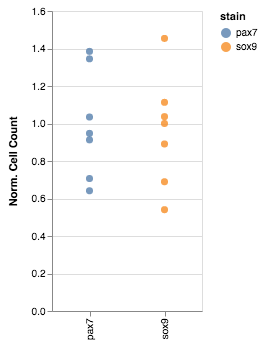

In [122]:
alt.Chart(avg_ratios_hh9_melted,
    width=150
    ).mark_point(
        size=50,
        filled=True,
        opacity=0.75
    ).encode(
        x=alt.X('stain:N',
            title=''),
        y=alt.Y('ratio:Q',
            title='Norm. Cell Count'),
        color='stain:N'
    )